In [1]:
#Load library and configuration parameters
#Denoising autoencoder
import torch
import torch.nn as nn
import torch.utils as utils
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
import scipy.io as sio

import os
import cv2

In [2]:
# Classes

# Target dataset
class CustomDataset(Dataset):

    def __init__(self, data_name, set_selection=0):
        
        target_path = '../30-Video_Feature_Generation/'
        data_meta = pd.read_csv(target_path +'output/' + data_name + '/meta_data.csv')      
        self.data = []
        
        if set_selection == 0:
            # get only train
            n_start = 0
            n_end = data_meta[data_meta['train_valid_test']=='valid'].index[0]
        elif set_selection == 1:
            # get only validation
            n_start = data_meta[data_meta['train_valid_test']=='valid'].index[0]
            n_end = data_meta[data_meta['train_valid_test']=='test'].index[0]
        else:
            # get everything, including test set
            n_start = 0
            n_end = len(data_meta)
            
        # read all data 
        for i in range(n_start, n_end):
            img_path = target_path + data_meta.loc[i, 'scaled_im_path'][2:]
            class_name = data_meta.loc[i, 'name']
            self.data.append([img_path, class_name])
            
        # read class types
        tmp = data_meta[['name','class']].drop_duplicates().sort_values(by='class').reset_index(drop=True)
        class_map_ = dict()
        for i in range(0, len(tmp)):
            name_ = tmp.loc[i, 'name']
            class_ = int(tmp.loc[i, 'class'])
            class_map_[name_] = class_
            
        self.class_map = class_map_
        self.img_dim = (64, 64)
        
    def __len__(self):
        
        return len(self.data)
    
    def __getitem__(self, idx):
        
        img_path, class_name = self.data[idx]
        # read
        img = cv2.imread(img_path, 0)
        # resize
        img = cv2.resize(img, self.img_dim)
        # normalize
        img = img/255.0
        # cast to float
        img = img.astype('float32')
        # expan dim
        img = np.expand_dims(img, axis=0)
        
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        #img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        
        return img_tensor, class_id
    
# Encoder settings
class Encoder(nn.Module):
    
    def __init__(self):
        
        super(Encoder,self).__init__()
        
        self.conv1=nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2)
        )
        
        self.maxpool1 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv2 = nn.Sequential(
            torch.nn.Conv2d(64, 50, 3, 1, 1),  
            torch.nn.BatchNorm2d(50),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool2 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv3 = nn.Sequential(
            torch.nn.Conv2d(50, 36, 3, 1, 1),
            torch.nn.BatchNorm2d(36),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool3 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv4 = nn.Sequential(
            torch.nn.Conv2d(36,22, 3, 1, 1),  
            torch.nn.BatchNorm2d(22),
            torch.nn.LeakyReLU(0.2))
        
        self.maxpool4 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
        self.conv5 = nn.Sequential(
            torch.nn.Conv2d(22, 8, 3, 1, 1),
            torch.nn.BatchNorm2d(8),
            torch.nn.Sigmoid())
        
        self.maxpool5 = nn.MaxPool2d(2, stride=2, return_indices=True)
        
    def forward(self, x_in):
        
        x = self.conv1(x_in)
        x , indices1 = self.maxpool1(x)
        x = self.conv2(x)
        x , indices2 = self.maxpool2(x)
        x = self.conv3(x)
        x , indices3 = self.maxpool3(x)
        x = self.conv4(x)
        x , indices4 = self.maxpool4(x)
        x = self.conv5(x)
        feature , indices5 = self.maxpool5(x)
        
        indices = [indices1, indices2, indices3, indices4, indices5]
        
        return feature, indices
    
# Decoder settings
class Decoder(nn.Module):
    
    def __init__(self):
        
        super(Decoder,self).__init__()
        
        self.convtrans1 = nn.Sequential(nn.ConvTranspose2d(8, 22, 3, 1, 1), )
        
        self.maxunpool1= nn.MaxUnpool2d(2, stride=2)
        
        self.convtrans2 = nn.Sequential(nn.ConvTranspose2d(22, 36, 3, 1, 1), )
        
        self.maxunpool2 = nn.MaxUnpool2d(2,stride=2)
        
        self.convtrans3 = nn.Sequential(nn.ConvTranspose2d(36, 50, 3, 1, 1), )
        
        self.maxunpool3 = nn.MaxUnpool2d(2, stride=2)
        
        self.convtrans4 = nn.Sequential(nn.ConvTranspose2d(50, 64, 3, 1, 1), )
        
        self.maxunpool4 = nn.MaxUnpool2d(2,stride=2)
        
        self.convtrans5 = nn.Sequential(nn.ConvTranspose2d(64, 1, 3, 1, 1), )
        
        self.maxunpool5 = nn.MaxUnpool2d(2,stride=2)
        
    def forward(self, x_in, indices):
        
        x = self.maxunpool1(x_in, indices[4])
        x = self.convtrans1(x)
        x = self.maxunpool2(x, indices[3])
        x = self.convtrans2(x)
        x = self.maxunpool3(x, indices[2])
        x = self.convtrans3(x)
        x = self.maxunpool4(x, indices[1])
        x = self.convtrans4(x)
        x = self.maxunpool5(x, indices[0])
        x = self.convtrans5(x)
        
        return x

In [3]:
#Configuration parameter

n_epoch = 100                 # Number of epochs
batch_size = 500              # Size of the batch
learning_rate = 0.01          # learning rate for ADAM optimizer
noise_std = 0.01              # This noise level is given in "https://arxiv.org/pdf/2012.01468.pdf"

target_data_name = 'UCSDped2'
#target_data_name = 'UCSDped1'

#target_data_name = 'ShangaiTech'
#target_data_name = 'SUrveillance'

In [4]:
# Read Meta data 
data_meta = pd.read_csv('./output/' + target_data_name + '/meta_data.csv')

# Read Yolo Objects and create torch datasets
data_train = CustomDataset(target_data_name, set_selection=0)
train_loader = DataLoader(data_train, batch_size = batch_size, shuffle=True)

data_valid = CustomDataset(target_data_name, set_selection=1)
valid_loader = DataLoader(data_valid, batch_size = batch_size)

data_all = CustomDataset(target_data_name, set_selection=2)
all_loader = DataLoader(data_all, batch_size = batch_size)

In [5]:
# Create the Autoencoder
encoder=Encoder().cuda()
decoder=Decoder().cuda()

# Loss functions and optimizers
parameters=list(encoder.parameters())+list(decoder.parameters())
loss_func=nn.MSELoss()
optimizer=torch.optim.Adam(parameters, lr=learning_rate, weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.6)

# Autoencoder training

# Create performance save arrays
train_avg_image_loss_acc = []
train_avg_batch_loss_acc = []
valid_avg_image_loss_acc = []
valid_avg_batch_loss_acc = []

for I in range(n_epoch):
    
    # run epoch
    print('Epoch: {}'.format(I))
    train_loss = 0.0
    num_of_images_train = 0.0
    for image,label in tqdm(train_loader):
        
        # get number of images
        num_of_images_train = num_of_images_train + image.shape[0]
        
        # create noise
        noise=torch.tensor(np.random.normal(loc=0, scale=noise_std, size=image.shape)).type(torch.FloatTensor)
        
        # create noise image
        image_n=torch.add(image, noise)
        
        # move images to GPU
        image=Variable(image).cuda()
        image_n=Variable(image_n).cuda()
        
        # clear gradients
        optimizer.zero_grad()
        
        # forward pass from DAE (encoder + decoder)
        latent_features, indices = encoder(image_n)
        output = decoder(latent_features, indices)
        
        # get loss
        loss = loss_func(output,image)
        
        # calculate gradients based on loss
        loss.backward()
        
        # Update Weights
        optimizer.step()
        
        # save training loss
        train_loss = train_loss + loss.item()
        
    # update scheduler
    scheduler.step()
    
    # average train image loss
    avg_train_image_loss = train_loss/num_of_images_train
    train_avg_image_loss_acc.append(avg_train_image_loss)
    
    # average train batch loss
    avg_train_batch_loss = train_loss/len(train_loader)
    train_avg_batch_loss_acc.append(avg_train_batch_loss)
    
    # calculate validation loss after epoch is completed
    # we are adding torch.no_grad because we do not want to save gradients calculated in the validation step
    with torch.no_grad():
        valid_loss = 0.0
        num_of_images_valid = 0.0
        for image_v, labels_v in valid_loader:

            # get number of images
            num_of_images_valid = num_of_images_valid + image_v.shape[0]

            # move images to GPU
            image_v=Variable(image_v).cuda()

            # forward pass from DAE (encoder + decoder)
            latent_features_v, indices_v = encoder(image_v)
            output_v = decoder(latent_features_v, indices_v)

            # get loss
            loss_v = loss_func(output_v, image_v)

            # save valid loss
            valid_loss = valid_loss + loss_v.item()
        
    # average valid image loss
    avg_valid_image_loss = valid_loss/num_of_images_valid
    valid_avg_image_loss_acc.append(avg_valid_image_loss)
    print('Validation avg image loss: {}'.format(avg_valid_image_loss))
    
    # average valid batch loss
    avg_valid_batch_loss = valid_loss/len(valid_loader)
    valid_avg_batch_loss_acc.append(avg_valid_batch_loss)
    print('Validation avg batch loss: {}'.format(avg_valid_batch_loss))

Epoch: 0


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:16<00:00,  3.16it/s]


Validation avg image loss: 1.7945384746767525e-05
Validation avg batch loss: 0.007955787237733603
Epoch: 1


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 1.3600111784959646e-05
Validation avg batch loss: 0.0060293828913321095
Epoch: 2


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 1.4405089598569207e-05
Validation avg batch loss: 0.006386256388699015
Epoch: 3


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.66it/s]


Validation avg image loss: 1.4310954768854872e-05
Validation avg batch loss: 0.0063445232808589935
Epoch: 4


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 2.381414861271256e-05
Validation avg batch loss: 0.010557605884969234
Epoch: 5


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 1.8435060151649597e-05
Validation avg batch loss: 0.008172876667231321
Epoch: 6


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 1.4158379972765321e-05
Validation avg batch loss: 0.006276881787925959
Epoch: 7


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 1.5592536034720733e-05
Validation avg batch loss: 0.0069126909753928585
Epoch: 8


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 1.3778649123483583e-05
Validation avg batch loss: 0.0061085344447443886
Epoch: 9


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 1.0348334593376272e-05
Validation avg batch loss: 0.0045877616697301464
Epoch: 10


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.67it/s]


Validation avg image loss: 1.0807968543044159e-05
Validation avg batch loss: 0.004791532720749577
Epoch: 11


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 1.0130041159857484e-05
Validation avg batch loss: 0.0044909849142034846
Epoch: 12


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 1.04275286981934e-05
Validation avg batch loss: 0.004622871056199074
Epoch: 13


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 1.3040985624985139e-05
Validation avg batch loss: 0.005781503627076745
Epoch: 14


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 9.701767222101528e-06
Validation avg batch loss: 0.004301116801798344
Epoch: 15


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.66it/s]


Validation avg image loss: 9.200117844892175e-06
Validation avg batch loss: 0.004078718911235531
Epoch: 16


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 1.6264191695622035e-05
Validation avg batch loss: 0.007210458318392436
Epoch: 17


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 1.2255014844686914e-05
Validation avg batch loss: 0.005433056581144531
Epoch: 18


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 1.1074939511604327e-05
Validation avg batch loss: 0.004909889850144585
Epoch: 19


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 1.093150883268817e-05
Validation avg batch loss: 0.0048463022491584224
Epoch: 20


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.73it/s]


Validation avg image loss: 1.3671633857477428e-05
Validation avg batch loss: 0.006061091010148327
Epoch: 21


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 1.096182040646112e-05
Validation avg batch loss: 0.0048597403801977634
Epoch: 22


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.73it/s]


Validation avg image loss: 1.136369099910546e-05
Validation avg batch loss: 0.005037903009603421
Epoch: 23


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.67it/s]


Validation avg image loss: 1.0140533594036462e-05
Validation avg batch loss: 0.004495636560022831
Epoch: 24


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.65it/s]


Validation avg image loss: 1.1682680184791858e-05
Validation avg batch loss: 0.005179321548591058
Epoch: 25


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.62it/s]


Validation avg image loss: 8.968433148150605e-06
Validation avg batch loss: 0.003976005362346768
Epoch: 26


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.65it/s]


Validation avg image loss: 9.233933869973385e-06
Validation avg batch loss: 0.0040937106823548675
Epoch: 27


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 9.165899530473284e-06
Validation avg batch loss: 0.004063548791843156
Epoch: 28


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 8.634764252972782e-06
Validation avg batch loss: 0.0038280788188179335
Epoch: 29


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 8.693977024518233e-06
Validation avg batch loss: 0.0038543298142030835
Epoch: 30


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 8.807469621524776e-06
Validation avg batch loss: 0.0039046448655426502
Epoch: 31


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 8.881677649355024e-06
Validation avg batch loss: 0.003937543757880728
Epoch: 32


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 9.213730559817382e-06
Validation avg batch loss: 0.004084753881519039
Epoch: 33


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 9.512306450116903e-06
Validation avg batch loss: 0.0042171225262184935
Epoch: 34


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.67it/s]


Validation avg image loss: 8.888294503680969e-06
Validation avg batch loss: 0.0039404772299652295
Epoch: 35


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 8.564464541334183e-06
Validation avg batch loss: 0.003796912613324821
Epoch: 36


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.73it/s]


Validation avg image loss: 1.3050227601053124e-05
Validation avg batch loss: 0.005785600903133552
Epoch: 37


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 8.322758586110925e-06
Validation avg batch loss: 0.0036897563065091767
Epoch: 38


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 9.505613269354392e-06
Validation avg batch loss: 0.004214155216080447
Epoch: 39


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 8.793269840762355e-06
Validation avg batch loss: 0.003898349629404644
Epoch: 40


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.64it/s]


Validation avg image loss: 9.17942217670213e-06
Validation avg batch loss: 0.004069543831671278
Epoch: 41


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.54it/s]


Validation avg image loss: 1.2146590515635067e-05
Validation avg batch loss: 0.005384988461931546
Epoch: 42


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.60it/s]


Validation avg image loss: 1.1032474353293279e-05
Validation avg batch loss: 0.00489106362996002
Epoch: 43


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.65it/s]


Validation avg image loss: 1.4088378476917295e-05
Validation avg batch loss: 0.006245847791433334
Epoch: 44


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.63it/s]


Validation avg image loss: 9.949357140305123e-06
Validation avg batch loss: 0.004410881665535271
Epoch: 45


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.59it/s]


Validation avg image loss: 1.0879477836135635e-05
Validation avg batch loss: 0.004823235174020131
Epoch: 46


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.62it/s]


Validation avg image loss: 1.0459757711094125e-05
Validation avg batch loss: 0.004637159251918395
Epoch: 47


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.61it/s]


Validation avg image loss: 1.0745241341734291e-05
Validation avg batch loss: 0.004763723661502202
Epoch: 48


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.66it/s]


Validation avg image loss: 9.720049504386752e-06
Validation avg batch loss: 0.004309221946944793
Epoch: 49


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 1.2409435129983532e-05
Validation avg batch loss: 0.005501516240959366
Epoch: 50


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 1.0026528944674516e-05
Validation avg batch loss: 0.004445094498805702
Epoch: 51


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 9.119325786604916e-06
Validation avg batch loss: 0.00404290109872818
Epoch: 52


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 9.726743647982751e-06
Validation avg batch loss: 0.00431218968393902
Epoch: 53


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.67it/s]


Validation avg image loss: 8.495220270259935e-06
Validation avg batch loss: 0.0037662143198152385
Epoch: 54


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 9.115114352924931e-06
Validation avg batch loss: 0.0040410340297967196
Epoch: 55


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 9.77071695365852e-06
Validation avg batch loss: 0.0043316845161219435
Epoch: 56


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.75it/s]


Validation avg image loss: 8.593875690734476e-06
Validation avg batch loss: 0.003809951556225618
Epoch: 57


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.75it/s]


Validation avg image loss: 1.1154321981663991e-05
Validation avg batch loss: 0.0049450827452043695
Epoch: 58


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.73it/s]


Validation avg image loss: 9.668459047920498e-06
Validation avg batch loss: 0.00428635017791142
Epoch: 59


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.64it/s]


Validation avg image loss: 9.827885192055675e-06
Validation avg batch loss: 0.004357029101811349
Epoch: 60


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 9.420324866204782e-06
Validation avg batch loss: 0.004176344024017453
Epoch: 61


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.68it/s]


Validation avg image loss: 9.564272149052834e-06
Validation avg batch loss: 0.004240160652746757
Epoch: 62


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 8.948326996646653e-06
Validation avg batch loss: 0.003967091635180016
Epoch: 63


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 8.399536153931814e-06
Validation avg batch loss: 0.003723794361576438
Epoch: 64


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 8.096585148259213e-06
Validation avg batch loss: 0.003589486082394918
Epoch: 65


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 8.829381348411167e-06
Validation avg batch loss: 0.0039143590644622845
Epoch: 66


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.73it/s]


Validation avg image loss: 8.207431091065693e-06
Validation avg batch loss: 0.003638627783705791
Epoch: 67


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 9.484745866682073e-06
Validation avg batch loss: 0.004204904000895719
Epoch: 68


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 8.024026541725586e-06
Validation avg batch loss: 0.003557318433498343
Epoch: 69


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 9.053810394572137e-06
Validation avg batch loss: 0.004013855941593647
Epoch: 70


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.74it/s]


Validation avg image loss: 7.845732537483362e-06
Validation avg batch loss: 0.0034782747582842908
Epoch: 71


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.73it/s]


Validation avg image loss: 8.058242667886548e-06
Validation avg batch loss: 0.0035724875827630362
Epoch: 72


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 7.952880937101921e-06
Validation avg batch loss: 0.0035257772154485187
Epoch: 73


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.63it/s]


Validation avg image loss: 1.0547112179850054e-05
Validation avg batch loss: 0.004675886399733524
Epoch: 74


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 9.863357728389197e-06
Validation avg batch loss: 0.004372755259585877
Epoch: 75


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.67it/s]


Validation avg image loss: 9.972626812531984e-06
Validation avg batch loss: 0.004421197886889179
Epoch: 76


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 8.707252135010143e-06
Validation avg batch loss: 0.0038602151131878295
Epoch: 77


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.57it/s]


Validation avg image loss: 8.674065190318384e-06
Validation avg batch loss: 0.0038455022343744836
Epoch: 78


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 7.704887766727155e-06
Validation avg batch loss: 0.003415833576582372
Epoch: 79


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.63it/s]


Validation avg image loss: 7.942313314380502e-06
Validation avg batch loss: 0.0035210922360420227
Epoch: 80


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.53it/s]


Validation avg image loss: 9.5984974658971e-06
Validation avg batch loss: 0.004255333876547714
Epoch: 81


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.55it/s]


Validation avg image loss: 8.566360710594886e-06
Validation avg batch loss: 0.0037977532483637333
Epoch: 82


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.58it/s]


Validation avg image loss: 7.787053438281654e-06
Validation avg batch loss: 0.0034522603576382003
Epoch: 83


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.63it/s]


Validation avg image loss: 9.726731481268665e-06
Validation avg batch loss: 0.0043121842900291085
Epoch: 84


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.64it/s]


Validation avg image loss: 7.787291520744338e-06
Validation avg batch loss: 0.0034523659075299897
Epoch: 85


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.59it/s]


Validation avg image loss: 8.875878240661065e-06
Validation avg batch loss: 0.003934972686693072
Epoch: 86


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.52it/s]


Validation avg image loss: 8.006548137873188e-06
Validation avg batch loss: 0.003549569674457113
Epoch: 87


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:14<00:00,  3.50it/s]


Validation avg image loss: 8.398447276786306e-06
Validation avg batch loss: 0.0037233116260419288
Epoch: 88


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.69it/s]


Validation avg image loss: 1.0558732092044408e-05
Validation avg batch loss: 0.0046810378941396875
Epoch: 89


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.67it/s]


Validation avg image loss: 8.564165800361706e-06
Validation avg batch loss: 0.003796780171493689
Epoch: 90


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.73it/s]


Validation avg image loss: 9.134397019205012e-06
Validation avg batch loss: 0.004049582678514223
Epoch: 91


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 8.046376970561599e-06
Validation avg batch loss: 0.0035672271236156425
Epoch: 92


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 1.0466016829013824e-05
Validation avg batch loss: 0.004639934127529462
Epoch: 93


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.67it/s]


Validation avg image loss: 7.80576794527303e-06
Validation avg batch loss: 0.0034605571224043765
Epoch: 94


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 8.087539240101674e-06
Validation avg batch loss: 0.003585475729778409
Epoch: 95


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.71it/s]


Validation avg image loss: 8.454301247471257e-06
Validation avg batch loss: 0.003748073553045591
Epoch: 96


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 8.014535629435589e-06
Validation avg batch loss: 0.0035531107957164445
Epoch: 97


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.72it/s]


Validation avg image loss: 8.478678178210232e-06
Validation avg batch loss: 0.003758880659006536
Epoch: 98


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.73it/s]


Validation avg image loss: 8.253214173579127e-06
Validation avg batch loss: 0.003658924950286746
Epoch: 99


100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [00:13<00:00,  3.70it/s]


Validation avg image loss: 7.979167604300761e-06
Validation avg batch loss: 0.003537430971240004


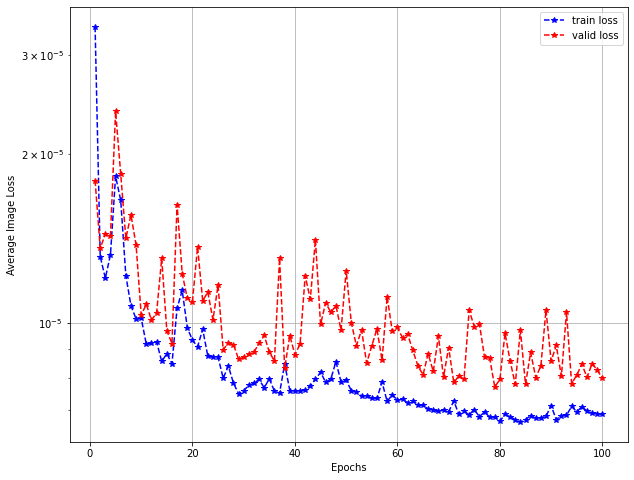

In [6]:
# create performance watch
x_epoch = list(range(1,n_epoch+1))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(x_epoch, train_avg_image_loss_acc, '--*b', label='train loss')
ax.plot(x_epoch, valid_avg_image_loss_acc, '--*r', label='valid loss')
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Average Image Loss')
plt.legend()
plt.grid()

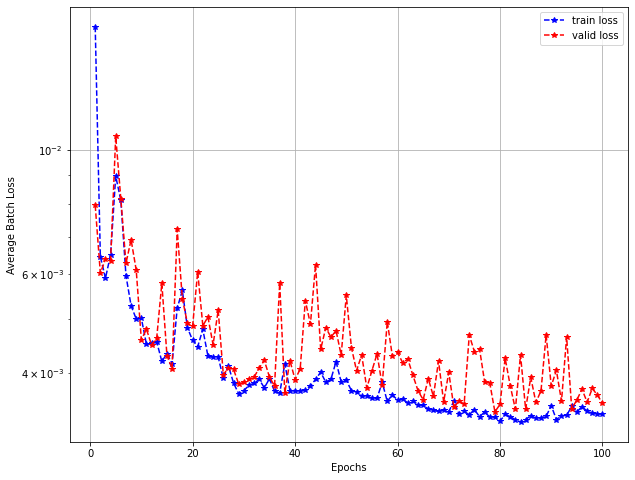

In [7]:
# create performance watch
x_epoch = list(range(1,n_epoch+1))
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.plot(x_epoch, train_avg_batch_loss_acc, '--*b', label='train loss')
ax.plot(x_epoch, valid_avg_batch_loss_acc, '--*r', label='valid loss')
plt.yscale("log")
plt.xlabel('Epochs')
plt.ylabel('Average Batch Loss')
plt.legend()
plt.grid()

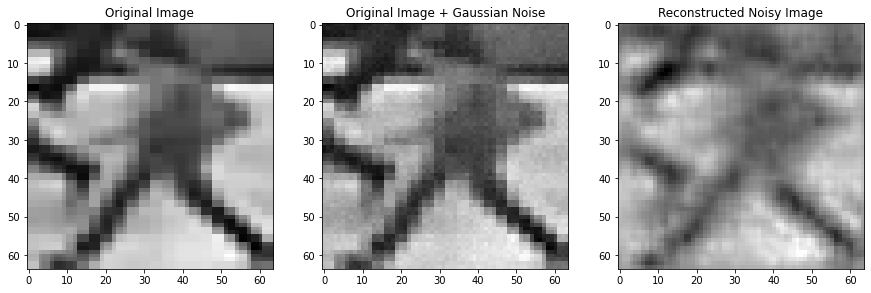

In [8]:
# Test couple of examples
test_image_index = 1
img=image[test_image_index].cpu()
input_img=image_n[test_image_index].cpu()
output_img=output[test_image_index].cpu()

origin=img.data.numpy()
inp=input_img.data.numpy()
out=output_img.data.numpy()

f, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(origin[0],cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(inp[0],cmap='gray')
axs[1].set_title('Original Image + Gaussian Noise')

axs[2].imshow(out[0],cmap='gray')
axs[2].set_title('Reconstructed Noisy Image')
plt.show()

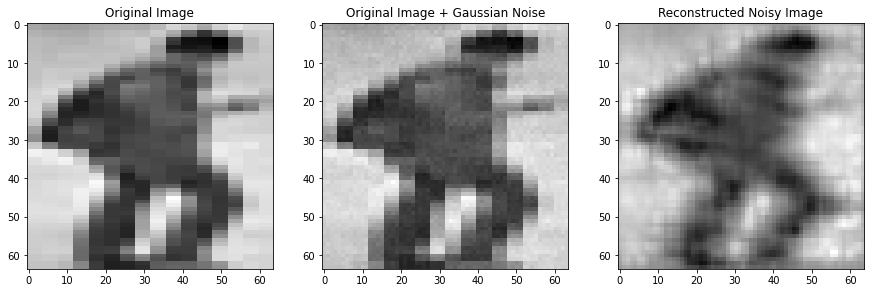

In [9]:
# Test couple of examples
test_image_index = 5
img=image[test_image_index].cpu()
input_img=image_n[test_image_index].cpu()
output_img=output[test_image_index].cpu()

origin=img.data.numpy()
inp=input_img.data.numpy()
out=output_img.data.numpy()

f, axs = plt.subplots(1,3,figsize=(15,15))
axs[0].imshow(origin[0],cmap='gray')
axs[0].set_title('Original Image')

axs[1].imshow(inp[0],cmap='gray')
axs[1].set_title('Original Image + Gaussian Noise')

axs[2].imshow(out[0],cmap='gray')
axs[2].set_title('Reconstructed Noisy Image')
plt.show()

In [10]:
# project all available data to latent space

n=len(data_all)
latents = np.zeros((n, 33)) #32 latent features + PSNR

for i in tqdm(range(n)):
    
    # get the sample
    sample, _ = data_all[i]
    sample = sample.cpu()
    tmp = np.expand_dims(sample, axis=0)   
    sample = torch.from_numpy(tmp)
    sample = Variable(sample).cuda()
    
    # get latent features
    latent_features, indices = encoder(sample)
    
    # get decoded image
    output = decoder(latent_features, indices)
    
    # save features
    z1 = latent_features.resize(1,32).cpu().detach().numpy()[0]
    latents[i,0:32] = z1
    
    mse = torch.mean(torch.pow(torch.sub(sample, output), 2)).cpu().detach().numpy()
    max_x = sample.max().cpu().detach().numpy()
    z2 = 10*np.log10(max_x/mse) # PSNR
    latents[i,32] = z2
    
# combine meta data and latent features
latent_pd = pd.DataFrame(latents, columns=['dae_latent_feature_{:02d}'.format(x) for x in range(33)])
latent_pd.rename(columns={'dae_latent_feature_32': 'spnr'}, inplace=True)
video_df = pd.concat([data_meta,latent_pd], axis=1)

  0%|                                                                                        | 0/58456 [00:00<?, ?it/s]c:\users\basarbatu\appdata\local\programs\python\python39\lib\site-packages\torch\_tensor.py:493: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")
100%|███████████████████████████████████████████████████████████████████████████| 58456/58456 [03:20<00:00, 290.96it/s]


In [11]:
# save output as mat to be used in matlab
out_df = {name: col.values for name, col in video_df.items()}
sio.savemat('./output/' + target_data_name + '/' + target_data_name + '_dae.mat', out_df)

In [12]:
len(out_df['train_valid_test'])

58456

In [13]:
sum(out_df['train_valid_test']=='train')/len(out_df['train_valid_test'])

0.4283563706035309

In [14]:
sum(out_df['train_valid_test']=='valid')/len(out_df['train_valid_test'])

0.045504310934720134

In [15]:
sum(out_df['train_valid_test']=='test')/len(out_df['train_valid_test'])

0.526139318461749